In [134]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
import numpy as np

import copy
import tensorflow as tf
from glob import glob
import rasterio
import os

x = str(115)
y = str(1329)

data = pd.read_csv("../../src/processing_area_june_28.csv")

<Figure size 720x576 with 0 Axes>

In [135]:
import yaml
%run ../../src/downloading/io.py
import glob

yaml_path = "../../config.yaml"
with open(yaml_path, 'r') as stream:
    key = (yaml.safe_load(stream))
    API_KEY= key['key']
    AWSKEY = key['awskey']
    AWSSECRET = key['awssecret']
print(f"Successfully loaded key from {yaml_path}")
uploader = FileUploader(awskey = AWSKEY, awssecret = AWSSECRET, overwrite = True)

path_to_process = f"../../project-monitoring/tiles/{str(x)}/{str(y)}/"
s3_path_to_process = f'2020/processed/{str(x)}/{str(y)}/'

download_folder(bucket = "tof-output",
                   apikey = AWSKEY,
                   apisecret = AWSSECRET,
                   local_dir = path_to_process,
                   s3_folder = s3_path_to_process)

Successfully loaded key from ../../config.yaml
s3.ObjectSummary(bucket_name='tof-output', key='2020/processed/115/1329/processed/0/0.npy')
s3.ObjectSummary(bucket_name='tof-output', key='2020/processed/115/1329/processed/0/119.npy')
s3.ObjectSummary(bucket_name='tof-output', key='2020/processed/115/1329/processed/0/238.npy')
s3.ObjectSummary(bucket_name='tof-output', key='2020/processed/115/1329/processed/0/358.npy')
s3.ObjectSummary(bucket_name='tof-output', key='2020/processed/115/1329/processed/0/478.npy')
s3.ObjectSummary(bucket_name='tof-output', key='2020/processed/115/1329/processed/110/0.npy')
s3.ObjectSummary(bucket_name='tof-output', key='2020/processed/115/1329/processed/110/119.npy')
s3.ObjectSummary(bucket_name='tof-output', key='2020/processed/115/1329/processed/110/238.npy')
s3.ObjectSummary(bucket_name='tof-output', key='2020/processed/115/1329/processed/110/358.npy')
s3.ObjectSummary(bucket_name='tof-output', key='2020/processed/115/1329/processed/110/478.npy')
s3.Obje

<Figure size 432x288 with 0 Axes>

In [136]:
import os
def fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g

def load_mosaic_predictions(out_folder: str) -> np.ndarray:
    """
    Loads the .npy subtile files in an output folder and mosaics the overlapping predictions
    to return a single .npy file of tree cover for the 6x6 km tile
    Additionally, applies post-processing threshold rules and implements no-data flag of 255
    
        Parameters:
         out_folder (os.Path): location of the prediction .npy files 
    
        Returns:
         predictions (np.ndarray): 6 x 6 km tree cover data as a uint8 from 0-100 w/ 255 no-data flag
    """
    test = np.load(out_folder + "0/0.npy")
    SIZE = test.shape[0]
    print(SIZE)
    x_tiles = [int(x) for x in os.listdir(out_folder) if '.DS' not in x]
    max_x = np.max(x_tiles) + SIZE
    for x_tile in x_tiles:
        y_tiles = [int(y[:-4]) for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
        max_y = np.max(y_tiles) + SIZE
    predictions = np.full((max_x, max_y, len(x_tiles) * len(y_tiles)), np.nan, dtype = np.float32)
    mults = np.full((max_x, max_y, len(x_tiles) * len(y_tiles)), 0, dtype = np.float32)
    i = 0
    for x_tile in x_tiles:
        y_tiles = [int(y[:-4]) for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
        for y_tile in y_tiles:
            output_file = out_folder + str(x_tile) + "/" + str(y_tile) + ".npy"
            if os.path.exists(output_file):
                prediction = np.load(output_file)
                if np.sum(prediction) < SIZE*SIZE*255:
                    prediction = (prediction * 100).T.astype(np.float32)
                    predictions[x_tile: x_tile+SIZE, y_tile:y_tile + SIZE, i] = prediction
                    mults[x_tile: x_tile+SIZE, y_tile:y_tile + SIZE, i] = fspecial_gauss(SIZE, 35)
                i += 1

    predictions = predictions.astype(np.float32)
    
    predictions_range = np.nanmax(predictions, axis=-1) - np.nanmin(predictions, axis=-1)
    mean_certain_pred = np.nanmean(predictions[predictions_range < 50])
    mean_uncertain_pred = np.nanmean(predictions[predictions_range > 50])
    
    overpredict = True if (mean_uncertain_pred - mean_certain_pred) > 0 else False
    underpredict = True if not overpredict else False
    
    if SIZE == 168:
        for i in range(predictions.shape[-1]):
            if overpredict:
                problem_tile = True if np.nanmean(predictions[..., i]) > mean_certain_pred else False
            if underpredict:
                problem_tile = True if np.nanmean(predictions[..., i]) < mean_certain_pred else False
            range_i = np.copy(predictions_range)
            range_i[np.isnan(predictions[..., i])] = np.nan
            range_i = range_i[~np.isnan(range_i)]
            if range_i.shape[0] > 0:
                range_i = np.reshape(range_i, (168 // 56, 56, 168 // 56, 56))
                range_i = np.mean(range_i, axis = (1, 3))
                print(np.max(range_i))
                n_outliers = np.sum(range_i > 50)
                if n_outliers >= 2 and problem_tile:
                    predictions[..., i] = np.nan
                    mults[..., i] = 0.
    
    mults = mults / np.sum(mults, axis = -1)[..., np.newaxis]
    predictions[predictions > 100] = np.nan
    out = np.copy(predictions)
    out = np.sum(np.isnan(out), axis = (2))
    n_preds = predictions.shape[-1]


    predictions = np.nansum(predictions * mults, axis = -1)
    predictions[out == n_preds] = np.nan
    predictions[np.isnan(predictions)] = 255.
    predictions[predictions <= .25*100] = 0.        
    predictions = np.around(predictions / 20, 0) * 20
    predictions[predictions > 100] = 255.
    predictions = predictions.astype(np.uint8)
    
    original_preds = np.copy(predictions)
    for x_i in range(0, predictions.shape[0] - 3):
        for y_i in range(0, predictions.shape[1] - 3):
            window = original_preds[x_i:x_i+3, y_i:y_i+3]
            if np.max(window) < 35:
                sum_under_35 = np.sum(np.logical_and(window > 10, window < 35))
                if np.logical_and(sum_under_35 > 6, sum_under_35 < 10):
                    window = 0.

            # This removes or mitigates some of the "noisiness" of individual trees
            # Which could have odd shapes depending on where they sit within or between
            # Sentinel pixels 
            if np.max(window) >= 25 and np.argmax(window) == 4:
                window_binary = window >= 25
                if np.sum(window_binary) < 4:
                    if np.sum(window_binary[1]) < 3 and np.sum(window_binary[:, 1]) < 3:
                        window[0, :] = 0
                        window[2, :] = 0
                        window[:, 0] = 0
                        window[:, 2] = 0
                    
    predictions = original_preds 

    

    return predictions

In [137]:
predictions = 51
predictions = np.around(predictions / 20) * 20
print(predictions)

60.0


In [138]:
smooth = load_mosaic_predictions(f"../../project-monitoring/tiles/{x}/{y}/processed/")
smooth = smooth.astype(np.uint8)


140


/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in greater


<AxesSubplot:>

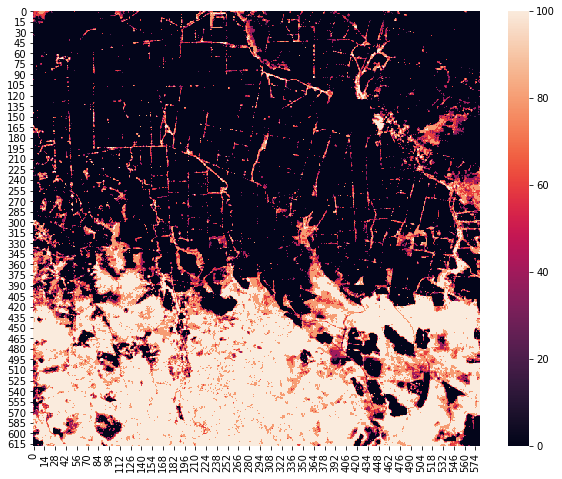

In [139]:
plt.figure(figsize=(10,8))
sns.heatmap(smooth.T, vmax = 100)

In [68]:

def make_bbox(initial_bbx: list, expansion: int = 10) -> list:
    """Makes a (min_x, min_y, max_x, max_y) bounding box that
       is 2 * expansion 300 x 300 meter ESA LULC pixels

       Parameters:
            initial_bbx (list): [min_x, min_y, max_x, max_y]
            expansion (int): 1/2 number of 300m pixels to expand

       Returns:
            bbx (list): expanded [min_x, min_y, max_x, max_y]
    """
    multiplier = 1/360 # Sentinel-2 pixel size in decimal degrees
    bbx = copy.deepcopy(initial_bbx)
    bbx[0] -= expansion * multiplier
    bbx[1] -= expansion * multiplier
    bbx[2] += expansion * multiplier
    bbx[3] += expansion * multiplier
    return bbx

data = data[data['Y_tile'] == int(y)]
data = data[data['X_tile'] == int(x)]
data = data.reset_index(drop = True)
x = str(int(x))
y = str(int(y))
x = x[:-2] if ".0" in x else x
y = y[:-2] if ".0" in y else y

initial_bbx = [data['X'][0], data['Y'][0], data['X'][0], data['Y'][0]]
bbx = make_bbox(initial_bbx, expansion = 300/30)

file = write_tif(smooth, bbx, x, y, f"../../project-monitoring/tiles/{x}/{y}/")
key = f'2020/tiles_nobin/{x}/{y}/{str(x)}X{str(y)}Y_POST.tif'
uploader.upload(bucket = 'tof-output', key = key, file = file)

Writing ../../project-monitoring/tiles/1409/1200/1409X1200Y_POST.tif


# NEw stuff

import pandas as pd
import boto3
import os
#data = pd.read_csv("reprocess.csv")
#data.head(5)

bucket = "tof-output"
s3 = boto3.client('s3', aws_access_key_id=AWSKEY,
         aws_secret_access_key= AWSSECRET)

for index, row in data.iterrows():
    x = str(int(row['X_tile']))
    y = str(int(row['Y_tile']))
    local_path = f"../../project-monitoring/tof-output/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_POST.tif"
    s3_path = f"2020/tiles/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_POST.tif"
    
    print(f"Deleting {x}/{y}")
    try:
        #s3.delete_object(Bucket = "tof-output", Key = s3_path)
    except:
        print(f"No file at: {s3_path}")
        continue
    try:
       # os.remove(local_path)
    except:
        continue